In [1]:
import wget
wget.download('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv', 'housing.csv')

100% [..........................................................................] 1423529 / 1423529

'housing.csv'

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

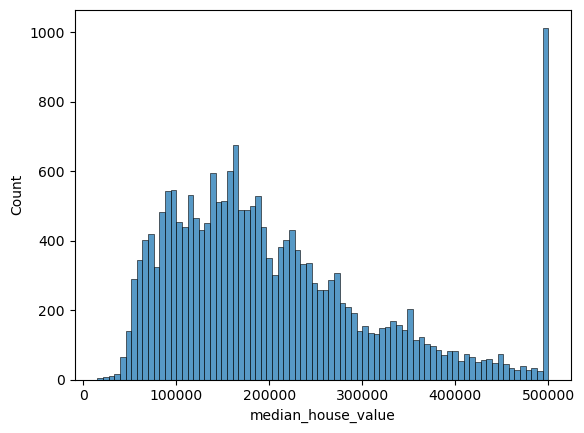

In [6]:
sns.histplot(df.median_house_value, bins = 80)

In [24]:
# use only selections variables
base_cols = ['latitude', 'longitude', 'housing_median_age', 'total_rooms',
             'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

df_used = df[base_cols]

## Question 1

### Find a feature with missing values. How many missing values does it have?

The feature is total_bedrooms with 207 missing values

In [8]:
df_used.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Question 2

### What's the median (50% percentile) for variable 'population'?



In [9]:
df_used.population.median()

1166.0

### Split the data
- Shuffle the initial dataset, use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Make sure that the target value ('median_house_value') is not in your dataframe.
- Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [59]:
n = len(df_used)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

# shuffle rows
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

# Split the data
df_train = df_used.iloc[idx[:n_train]].reset_index(drop = True)
df_val = df_used.iloc[idx[n_train:n_train + n_val]].reset_index(drop = True)
df_test = df_used.iloc[idx[n_train + n_val:]].reset_index(drop = True)

# Apply log transformation
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

# delete dependent variable from X dataframe
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [61]:
len(df_train) + len(df_val) + len(df_test)

20640

## Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)

### Which option gives better RMSE?

Both are equally good

In [27]:
base = ['latitude', 'longitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income']

In [37]:
df_train.mean()

latitude                35.610346
longitude             -119.555670
housing_median_age      28.699855
total_rooms           2619.001453
total_bedrooms         533.480332
population            1413.292151
households             495.653666
median_income            3.871533
dtype: float64

In [40]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [41]:
def train_linear_regression_reg(X, y, r = 0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [42]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [43]:
X_train = prepare_X(df_train)
w0,w = train_linear_regression_reg(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

round(rmse(y_val, y_pred),2)

0.33

In [44]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df_num = df[features]
    df_num = df_num.fillna(df_num.mean())
    X = df_num.values
    return X

In [45]:
X_train = prepare_X(df_train)
w0,w = train_linear_regression_reg(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

round(rmse(y_val, y_pred),2)

0.33

## Question 4

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.

### Which r gives the best RMSE?

In [48]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [54]:
score_list = []

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train = prepare_X(df_train)
    w0,w = train_linear_regression_reg(X_train, y_train, r = r)
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)

    score = round(rmse(y_val, y_pred),2)
    score_list.append(score)
    print(r, w0, score)

0 -11.686975241911805 0.33
1e-06 -11.686959176106466 0.33
0.0001 -11.685368865381463 0.33
0.001 -11.670931318209552 0.33
0.01 -11.528493585718884 0.33
0.1 -10.274500282155724 0.33
1 -4.920480897785023 0.33
5 -1.482095745620537 0.34
10 -0.7899311832204973 0.34


In [58]:
idx = np.argmin(score_list) # get index of score list with minimum value
idx

0

## Question 5

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

In [63]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [64]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]


In [76]:
n = len(df_used)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
score_list = []

for seed_input in  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # shuffle rows
    idx = np.arange(n)
    np.random.seed(seed_input)
    np.random.shuffle(idx)

    # Split the data
    df_train = df_used.iloc[idx[:n_train]].reset_index(drop = True)
    df_val = df_used.iloc[idx[n_train:n_train + n_val]].reset_index(drop = True)
    df_test = df_used.iloc[idx[n_train + n_val:]].reset_index(drop = True)

    # Apply log transformation
    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    # delete dependent variable from X dataframe
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    X_train = prepare_X(df_train)
    w0,w = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)
    score_list.append(score)
    

In [77]:
round(np.std(score_list),3)

0.004

## Question 6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.

### What's the RMSE on the test dataset?

In [ ]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

# Split the data
df_train = df_used.iloc[idx[:n_train]].reset_index(drop = True)
df_val = df_used.iloc[idx[n_train:n_train + n_val]].reset_index(drop = True)
df_test = df_used.iloc[idx[n_train + n_val:]].reset_index(drop = True)

# Apply log transformation
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

# delete dependent variable from X dataframe
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [78]:
df_full_train = pd.concat([df_train, df_val])
y_full_train = np.concatenate([y_train, y_val])

In [82]:
X_full_train = prepare_X(df_full_train)
w0,w = train_linear_regression_reg(X_full_train, y_full_train, r = 0.001)
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)

rmse(y_test, y_pred)


0.34531689143895133